# Durchführung des $\chi^2$-Tests

In [24]:
using Revise, Plots, LsqFit, Measurements
includet("run_tools.jl")
using .RunTools

In [25]:
#Definiere Inputpfade
in_path_P67_500 = "Data/messung_500V_P67_2700.txt";

#Definiere Outputpfade
out_path_P67_500_div = "out/divide/messung_500_P6_div.txt";

## Extrahiere die Aufteilung

In [26]:
D_t = 10.0;

data_P67_500_div = run_divide(in_path_P67_500, D_t, out_path_P67_500_div);

div_x = data_P67_500_div[:,1];
div_y = data_P67_500_div[:,2];

## Definiere Funktionen für $\chi^2$-Test

In [27]:
# chi^2 Test
function calc_m(div_y)
    d = length(div_y);

    return 1/d * sum(div_y);
end;


function calc_chi_sqrd(div_y, m)

    return sum(((div_y .- m).^2 ./m));
end;


#Totzeitkorrigierte chi^2-Test
function calc_m_corr(div_y, D_t, tau,m)
    d = length(div_y);
    k = div_y ./ (1 - m/D_t * tau);

    return 1/d * sum(k);
end;


function calc_chi_sqrd_corr(div_y, D_t, tau ,m ,m_corr)
    k = div_y ./ (1 - m/D_t * tau);

    return sum((k .- m_corr).^2)./m_corr;
end;


#Nehme an oder lehne ab
function is_correct(chi_sqrd::Number, interval::Vector{Float64})
    if length(interval) != 2
        println("Interval muss zwei Werte enthalten");
        return;
    end

    if chi_sqrd >= minimum(interval) && chi_sqrd <= maximum(interval)
        return true
    else
        return false
    end
end;

## Führe $\chi^2$-Tests durch

### Extrahiere 51 Werte, definiere Totzeit

In [28]:
data = div_y[1:51];
tau = measurement(3.92, 0.24) * 1e-3;
interval = [32.4,71.4];

### Konstanter Mittelwert

In [29]:
#Annahe Bereich definieren

m_const = calc_m(data);
chi_sqrd_const = calc_chi_sqrd(data, m_const);

m_const_corr = calc_m_corr(data, D_t, tau, m_const);
chi_sqrd_const_corr = calc_chi_sqrd_corr(data, D_t, tau, m_const, m_const_corr);

is_correct(chi_sqrd_const, interval), is_correct(chi_sqrd_const_corr, interval);


println("m_const: ", m_const, "\nchi_sqrd_const: ", chi_sqrd_const);
println("\nm_const_corr: ", m_const_corr, "\nchi_sqrd_const_corr: ", chi_sqrd_const_corr);
println("\n", is_correct(chi_sqrd_const, interval), "\n", is_correct(chi_sqrd_const_corr, interval));

m_const: 907.7647058823529
chi_sqrd_const: 37.87234318299637

m_const_corr: 1409.0 ± 48.0
chi_sqrd_const_corr: 58.8 ± 2.0

true
true


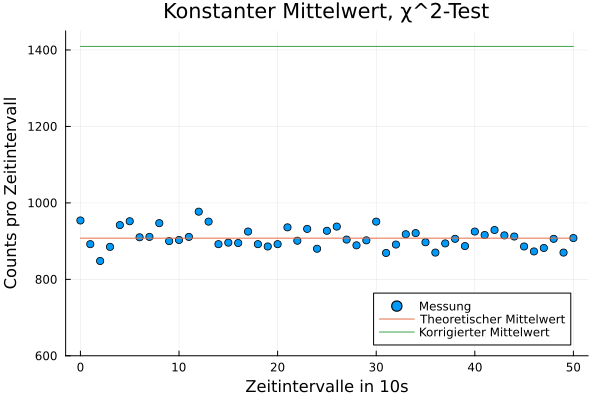

In [30]:
fig_m_const = plot(
    title = "Konstanter Mittelwert, χ^2-Test",
    xlabel = "Zeitintervalle in 10s",
    ylabel = "Counts pro Zeitintervall",
    div_x[1:51], data,
    seriestype=:scatter,
    label="Messung",
    ylim = (600, 1450)
);

plot!(t -> m_const, label="Theoretischer Mittelwert");
plot!(t -> m_const_corr.val, label="Korrigierter Mittelwert");

savefig(fig_m_const, "Plots/Chi_sqrd/m_const.png");

display(fig_m_const);

### Konstanter Mittelwert $- 10\%$

In [31]:
m_10perc = m_const*0.9;
m_10perc_corr = m_const_corr * 0.9;

chi_sqrd_10perc = calc_chi_sqrd(data, m_10perc);
chi_sqrd_10perc_corr = calc_chi_sqrd_corr(data, D_t, tau, m_10perc, m_10perc_corr);

is_correct(chi_sqrd_10perc, interval), is_correct(chi_sqrd_10perc_corr, interval)

println("\nm_10perc: ", m_10perc, "\nchi_sqrd_10perc: ", chi_sqrd_10perc);
println("\nm_10perc_corr: ", m_10perc_corr, "\nchi_sqrd_10perc_corr: ", chi_sqrd_10perc_corr);
println("\n", is_correct(chi_sqrd_10perc, interval), "\n", is_correct(chi_sqrd_10perc_corr, interval));


m_10perc: 816.9882352941177
chi_sqrd_10perc: 556.4803813144404

m_10perc_corr: 1268.0 ± 43.0
chi_sqrd_10perc_corr: 240.0 ± 28.0

false
false


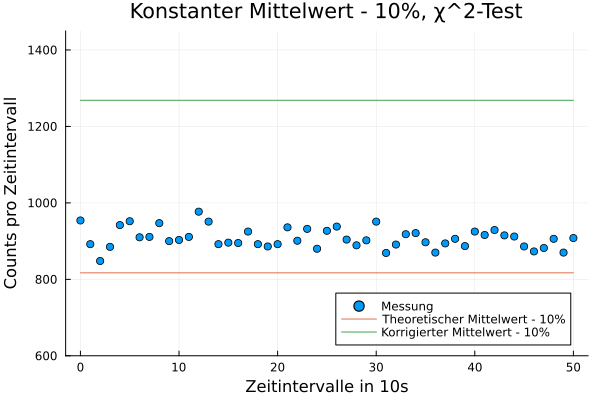

In [32]:
fig_m_10perc = plot(
    title = "Konstanter Mittelwert - 10%, χ^2-Test",
    xlabel = "Zeitintervalle in 10s",
    ylabel = "Counts pro Zeitintervall",
    div_x[1:51], data,
    seriestype=:scatter,
    label="Messung",
    ylim = (600, 1450)
);

plot!(t -> m_10perc, label="Theoretischer Mittelwert - 10%");
plot!(t -> m_10perc_corr.val, label="Korrigierter Mittelwert - 10%");

savefig(fig_m_10perc, "Plots/Chi_sqrd/m_10perc.png");

display(fig_m_10perc);

### Mittelwert fällt linear um 1 ab

In [41]:
m_lin = zeros(51);
m_lin[1] = m_const;

for i in 2:51
    m_lin[i] = m_lin[i-1] - 1;
end;

chi_sqrd_lin = 0;
for i in 1:51
    chi_sqrd_lin += calc_chi_sqrd(data[i], m_lin[i]);
end;

m_lin_corr = [calc_m_corr(data, D_t, tau.val, m_lin[i]) for i in 1:51];
chi_sqrd_lin_corr = 0;
for i in 1:51
    chi_sqrd_lin_corr += calc_chi_sqrd_corr(data[i], D_t, tau.val, m_lin[i], m_lin_corr[i]);
end;

is_correct(chi_sqrd_lin, interval), is_correct(chi_sqrd_lin_corr, interval)

println("\nchi_sqrd_lin: ", chi_sqrd_lin);
println("\nchi_sqrd_lin_corr: ", chi_sqrd_lin_corr);
println("\n", is_correct(chi_sqrd_lin, interval), "\n", is_correct(chi_sqrd_lin_corr, interval));


chi_sqrd_lin: 76.88004556527383

chi_sqrd_lin_corr: 58.12026758687299

false
true


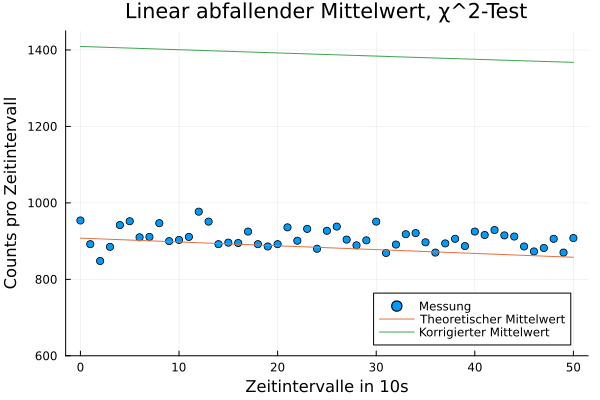

In [38]:
fig_m_lin = plot(
    title = "Linear abfallender Mittelwert, χ^2-Test",
    xlabel = "Zeitintervalle in 10s",
    ylabel = "Counts pro Zeitintervall",
    div_x[1:51], data,
    seriestype=:scatter,
    label="Messung",
    ylim = (600, 1450)
);

plot!(div_x[1:51], m_lin, label="Theoretischer Mittelwert");
plot!(div_x[1:51], m_lin_corr, label="Korrigierter Mittelwert");

savefig(fig_m_lin, "Plots/Chi_sqrd/m_lin.png");

display(fig_m_lin);

### Berechnung der Halbwertszeit

In [54]:
@show lamda = 1/(D_t * m_lin[1])/1e-6;
@show T_12 = log(2) * m_lin[1] * D_t/60/60;

lamda = (1 / (D_t * m_lin[1])) / 1.0e-6 = 110.16070502851218
T_12 = ((log(2) * m_lin[1] * D_t) / 60) / 60 = 1.747818184706058
